In [137]:
import hopsy
import numpy as np
import arviz as az

import x3c2fluxpy as x3c
#import x3cflux2adapter as _x3c

import time

from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D

import warnings
from multiprocessing import Pool

import dill
from tqdm.notebook import tqdm

import corner

session = "bruteforce"

plt.rcParams["font.family"] = "serif"
#plt.rcParams['font.serif'] = ["Times"]
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['axes.linewidth'] = .2
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = .2
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = .2

dpi=300
figsize=np.array([6.4,4.8])

In [139]:
from experimental_setup import *

TypeError: (): incompatible function arguments. The following argument types are supported:
    1. (self: hopsy.core.Problem, arg0: Optional[numpy.ndarray[numpy.float64[m, 1]]]) -> None

Invoked with: hopsy.Problem(A=array([[ 117.85112843, -204.12414217],
       [-333.33332833,    0.        ],
       [ 166.66666417,  288.67513026]]), b=array([235.7022604 , 333.33333333, 333.33333333]), model=PyModel(model=<x3c2fluxpy.X3CModel object at 0x7f780c759970>), transformation=array([[333.33332833,   0.        ],
       [166.66666417, 288.67513026]]), shift=array([333.33333333, 666.66666667])), [array([ 533.33333033, 1055.34179543])]

In [158]:
dims = [2]#, 5, 10, 20]#, 30, 50]

n_parallel = 50
n_seeds = 5
n_chains = 10

n_samples = 10_000
n_samples_order = 1

rhat_threshold=1.05
#N_max = 20
N_max = 1

fine, coarse = 16, 5 

problems = {
    "STAT-1": {
        "default": [(model.A.shape[1], hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1000, 1000)) for model in [x3c.X3CModel("models/Spiralus_STAT_unimodal.fml")]][0],
        "rounded": [(model.A.shape[1], hopsy.round(hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1000, 1000))) for model in [x3c.X3CModel("models/Spiralus_STAT_unimodal.fml")]][0],
    },
    "STAT-1-ni": {
        "default": [(model.A.shape[1], hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1000, 1000)) for model in [x3c.X3CModel("models/Spiralus_STAT_unimodal_ni.fml")]][0], 
        "rounded": [(model.A.shape[1], hopsy.round(hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1000, 1000))) for model in [x3c.X3CModel("models/Spiralus_STAT_unimodal_ni.fml")]][0], 
    },
    "STAT-2": {
        "default": [(model.A.shape[1], hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model, model.initial_point), -1000, 1000)) for model in [x3c.X3CModel("models/Spiralus_STAT_bimodal.fml")]][0], #+
        "rounded": [(model.A.shape[1], hopsy.round(hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1000, 1000))) for model in [x3c.X3CModel("models/Spiralus_STAT_bimodal.fml")]][0], #+
    },
    "STAT-2-ni": {
        "default": [(model.A.shape[1], hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1000, 1000)) for model in [x3c.X3CModel("models/Spiralus_STAT_bimodal_ni.fml")]][0], #+
        "rounded": [(model.A.shape[1], hopsy.round(hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model), -1000, 1000))) for model in [x3c.X3CModel("models/Spiralus_STAT_bimodal_ni.fml")]][0], #+
    },
}

starting_points = {
    "STAT-1": {
        "default": [[.6, 1]],
        "rounded": [],
    },
    "STAT-1-ni": {
        "default": [[.6, .05, 1]],
        "rounded": [], 
    },
    "STAT-2": {
        "default": [[.8, 1], [.2, 1]],
        "rounded": [],
    },
    "STAT-2-ni": {
        "default": [[.7, 0.01, 1], [.1, 0.01, 1]],
        "rounded": [],
    },
}

for key in problems:
    T, s = problems[key]['rounded'][1].transformation, problems[key]['rounded'][1].shift
    starting_points[key]['rounded'] = [T @ x + s for x in starting_points[key]['default']]
    print(starting_points[key]['rounded'])

proposals = {
#    "Adaptive Metropolis": hopsy.AdaptiveMetropolisProposal,
    "BallWalk": hopsy.BallWalkProposal,
    "CSmMALA": hopsy.CSmMALAProposal,
    "DikinWalk": hopsy.DikinWalkProposal,
    "Gaussian": hopsy.GaussianProposal,
    "Gaussian\nHit-And-Run": hopsy.GaussianHitAndRunProposal,
    "Rounding BallWalk": hopsy.BallWalkProposal,
    "Rounding Gaussian": hopsy.GaussianProposal,
    "Rounding Gaussian\nHit-And-Run": hopsy.GaussianHitAndRunProposal,
}

# last 3 algorithms will use rounding
rounding = {
    proposal: (i >= len(proposals) - 3) for i, proposal in enumerate(proposals)
}

def get_stepsize_grid(m, l, a = -5, b = 3):
    m, l = 0, 1
    a, b = -5, 3
    return np.hstack([
        np.linspace(a, m-l, coarse * (m-l-a) + 1)[:-1],
        np.linspace(m-l, m+l, fine * 2* l + 1)[:-1], 
        np.linspace(m+l, b, coarse * (b-m-l) + 1)
    ])    
        
# m, l, a, b
grid_params = {
    ('STAT-1', 'BallWalk'): (-1, 1),
    ('STAT-1', 'CSmMALA'): (.5, 1.5),
    ('STAT-1', 'DikinWalk'): (-2, 2),
    ('STAT-1', 'Gaussian'): (-1, 1),
    ('STAT-1', 'Gaussian\nHit-And-Run'): (-1, 1),
    ('STAT-1-ni', 'BallWalk'): (-1, 1),
    ('STAT-1-ni', 'CSmMALA'): (-1, 1),
    ('STAT-1-ni', 'DikinWalk'): (-1, 1),
    ('STAT-1-ni', 'Gaussian'): (-1.5, 1),
    ('STAT-1-ni', 'Gaussian\nHit-And-Run'): (-1, 1),
    ('STAT-2', 'BallWalk'): (-.5, 1.5),
    ('STAT-2', 'CSmMALA'): (.5, 1,5),
    ('STAT-2', 'DikinWalk'): (0, 2),
    ('STAT-2', 'Gaussian'): (0, 1.5),
    ('STAT-2', 'Gaussian\nHit-And-Run'): (-1, 1),
    ('STAT-2-ni', 'BallWalk'): (-.5, 1.5),
    ('STAT-2-ni', 'CSmMALA'): (-1, 1),
    ('STAT-2-ni', 'DikinWalk'): (-1, 1),
    ('STAT-2-ni', 'Gaussian'): (-1, 1),
    ('STAT-2-ni', 'Gaussian\nHit-And-Run'): (-1, 1),
}

stepsize_grids = {(problem, proposal): get_stepsize_grid(*grid_params[(problem, proposal)]) if (problem, proposal) in grid_params else get_stepsize_grid(-1, 1) for problem in problems for proposal in proposals}

targets = {
    "neff": (lambda rhat, elapsed, accrate, states: [np.min(hopsy.ess(states))]*n_chains),
    "neff/t": (lambda rhat, elapsed, accrate, states: [np.min(hopsy.ess(states)) / (elapsed / states.shape[1])]*n_chains),
    "rhat": (lambda rhat, elapsed, accrate, states: [rhat]*n_chains),
    "acc": (lambda rhat, elapsed, accrate, states: np.mean(accrate, axis=0)),
    "esjd": (lambda rhat, elapsed, accrate, states: np.mean(np.linalg.norm(np.diff(states, axis=1), axis=-1)**2, axis=-1)),
    "esjd/t": (lambda rhat, elapsed, accrate, states: np.mean(np.linalg.norm(np.diff(states, axis=1), axis=-1)**2, axis=-1) / (elapsed / states.shape[1])),
    "t": (lambda rhat, elapsed, accrate, states: [elapsed / states.shape[1]]*n_chains),
}

target_display_names = {
    "neff":   r"min $n_{\mathrm{eff}}$",
    "neff/t": r"min $n_{\mathrm{eff}}/t$",
    "rhat":   r"max $\hat{R}$",
    "acc":    "Acceptance rate",
    "esjd":   "ESJD",
    "esjd/t": "$\mathrm{ESJD}/t$",
    "t":      "$T/n$",
}

def uniform_sampling(problem):
    mcs = [hopsy.MarkovChain(problem, hopsy.UniformHitAndRunProposal) for i in range(n_chains)]
    rngs = [hopsy.RandomNumberGenerator(seed, i) for i in range(n_chains)]

    accrate, states = hopsy.sample(mcs, rngs, n_samples, dim)
    rhat = np.max(hopsy.rhat(states))
    
    i = 0
    while not(rhat < rhat_threshold) and i < n_max:
        _accrate, _states = hopsy.sample(mcs, rngs, n_samples, dim)
        
        states = np.concatenate([states, _states], axis=1)
        rhat = np.max(hopsy.rhat(states))
        
        i += 1
        
    return states


opt_sampling = {'STAT-1': ('CSmMALA', 4.39397056076079), 'STAT-1-ni': ('Gaussian\nHit-And-Run', 0.1), 'STAT-2': ('Gaussian\nHit-And-Run', 0.1), 'STAT-2-ni': ('Gaussian\nHit-And-Run', 1)}

def posterior_sampling(problem, Proposal, stepsize):
    mcs = [hopsy.MarkovChain(problem, hopsy.UniformHitAndRunProposal) for i in range(n_chains)]
    for mc in mcs: mc.proposal.stepsize = stepsize
    rngs = [hopsy.RandomNumberGenerator(seed, i) for i in range(n_chains)]

    accrate, states = hopsy.sample(mcs, rngs, n_samples, dim)
    rhat = np.max(hopsy.rhat(states))
    
    i = 0
    while not(rhat < rhat_threshold) and i < n_max:
        _accrate, _states = hopsy.sample(mcs, rngs, n_samples, dim)
        
        states = np.concatenate([states, _states], axis=1)
        rhat = np.max(hopsy.rhat(states))
        
        i += 1
        
    return states


def bruteforce_sampling(Proposal, problem, dim, starting_points, stepsize, seed):
    """
        Samples problem using a proposal of type Proposal from starting_point and with
        stepsize.
    """
    mcs = [hopsy.MarkovChain(problem, Proposal, starting_points[i]) for i in range(n_chains)]
    for mc in mcs: mc.proposal.stepsize = stepsize
    rngs = [hopsy.RandomNumberGenerator(seed, i) for i in range(n_chains)]

    elapsed = time.time()
    accrate, states = hopsy.sample(mcs, rngs, n_samples, dim)
    elapsed = time.time() - elapsed
    rhat = np.max(hopsy.rhat(states))
    
    accrate = [accrate]
    
    i = 0
    while not(rhat < rhat_threshold) and i < N_max:
        elapsed = time.time() - elapsed
        _accrate, _states = hopsy.sample(mcs, rngs, n_samples, dim)
        elapsed = time.time() - elapsed
        
        accrate += [_accrate]
        states = np.concatenate([states, _states], axis=1)
        
        rhat = np.max(hopsy.rhat(states))
        
        i += 1
        
    result = []
    for _, target in targets.items():
        result.append(target(rhat, elapsed/n_chains, np.array(accrate), states))
        
    return result


args = []
args_idx = []
args_key = []

for problem_key in problems:
    n_jobs = len(args)
    _problems = problems[problem_key]
    for proposal_key, Proposal in proposals.items():
        if rounding[proposal_key]:
            variant = "rounded"
        else:
            variant = "default"
            
        dim, problem = _problems[variant]
            
        for stepsize in stepsize_grid:
            for seed in range(n_seeds):
                rng = hopsy.RandomNumberGenerator(seed, n_chains)
                uniform = hopsy.Uniform(0, len(starting_points[problem_key][variant]))
                draws = [int(uniform(rng)) for i in range(n_chains)]
                
                _starting_points = [starting_points[problem_key][variant][i] for i in draws]
                
                args += [(Proposal, problem, dim, starting_points, stepsize, seed)]
    n_jobs = len(args) - n_jobs
    args_key += [problem_key] * n_jobs # all these new elements belong to problem_key
    
args_idx += [(problem, proposal, i, seed) for problem in problems
                               for proposal in enumerate(proposals)
                               for i in enumerate(stepsize_grid)
                               for seed in range(n_seeds)]

#print(len(args), len(args_key), len(args_idx))

[array([ 533.33333033, 1055.34179543])]
[array([ 533.33333033,  524.9999995 , 1055.34179543])]
[array([2.99999998, 5.44337564]), array([2.        , 4.94337565])]
[array([  2.83333332, 504.9999999 ,   5.36004231]), array([  1.83333333, 504.9999999 ,   4.86004232])]
11040 11040 11040


In [ ]:
print(len(args))

parallel = True
if parallel:
    with Pool(n_parallel) as p:
        data_arr = p.starmap(f, args)
else:
    data_arr = []
    for arg in args:
        data_arr.append(f(*arg))

with open("data/" + session + '_data', "wb") as fhandle:
    dill.dump(data_arr, fhandle)
    !git add data/* && git commit -m "bruteforce run"

6900


/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (be

In [10]:
with open("data/" + session + '_raw', "rb") as fhandle:
    data_arr = dill.load(fhandle)
    
results = {(problem, proposal): None for problem in problems for proposal in proposals}
data = {(problem, proposal): [] for problem in problems for proposal in proposals}
for i, (problem, proposal, j, seed) in args:
    data[(problem, proposal)] += [data_arr[i]]

for problem in problems:
    for proposal in proposals:
    shape = (len(targets), len(stepsize_grids[(problem, proposal)]), n_seeds, n_chains)
    results[(problem, proposal)] = np.zeros(shape)
    
    for data_idx, _data in enumerate(data[problem_key]):
        proposal_idx, problem_idx, stepsize_idx, seed = args_idx[problem_key][data_idx]
        
        results[problem_key][proposal_idx, problem_idx, :, stepsize_idx, seed] = np.array(data[problem_key][data_idx])
        
with open("data/" + session + '_data', "wb") as fhandle:
    dill.dump(results, fhandle)
    !git add data/*_time_gps && git commit -m "added time-per-sample posterior gps"

In [ ]:
def kernel(x, y, l = 1, sigma = 1):
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)
  
def posterior(x, x_obs, y_obs, l = 1, sigma_f = 1, sigma_y = 0, prior_mu = 0):
    K = kernel(x_obs, x_obs, l, sigma_f) + sigma_y * np.eye(len(x_obs))
    K_s = kernel(x_obs, x, l, sigma_f)
    K_ss = kernel(x, x, l, sigma_f)
    K_inv = np.linalg.inv(K)

    mu = prior_mu + K_s.T.dot(K_inv).dot(y_obs - prior_mu)
    cov = K_ss - K_s.T.dot(K_inv).dot(K_s) #+ sigma_y * np.eye(len(x))

    return mu, cov

gps = dict()

N = 200

for problem_key in problems:
    shape = (len(proposals), len(problems[problem_key]), N, 2)
    gps[problem_key] = np.zeros(shape)
        
for i, problem_key in enumerate(problems):
    for proposal_idx, (proposal_name, proposal) in enumerate(proposals.items()):
        for problem_idx, (dim, _, _) in enumerate(problems[problem_key]):
            target = "T/n"
            target_idx = list(targets).index(target)

            y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)
            y_mean = np.mean(y, axis=-1) 

            y /= np.max(y_mean)
            y_mean /= np.max(y_mean)

            X, Y = np.array([np.log10(stepsize_grid)]*y.shape[-1]).T.flatten().reshape(-1, 1), y.flatten().reshape(-1, 1)

            _x = np.linspace(-5, 3, N).reshape(-1, 1)
            mu, cov = posterior(_x, X, Y, sigma_y=.1, l=2)
            gps[problem_key][proposal_idx, problem_idx, :, 0] = mu.flatten()
            gps[problem_key][proposal_idx, problem_idx, :, 1] = np.sqrt(np.diag(cov)).flatten()

with open("data/" + session + '_time_gps', "wb") as fhandle:
    dill.dump(gps, fhandle)
    !git add data/*_time_gps && git commit -m "added time-per-sample posterior gps"

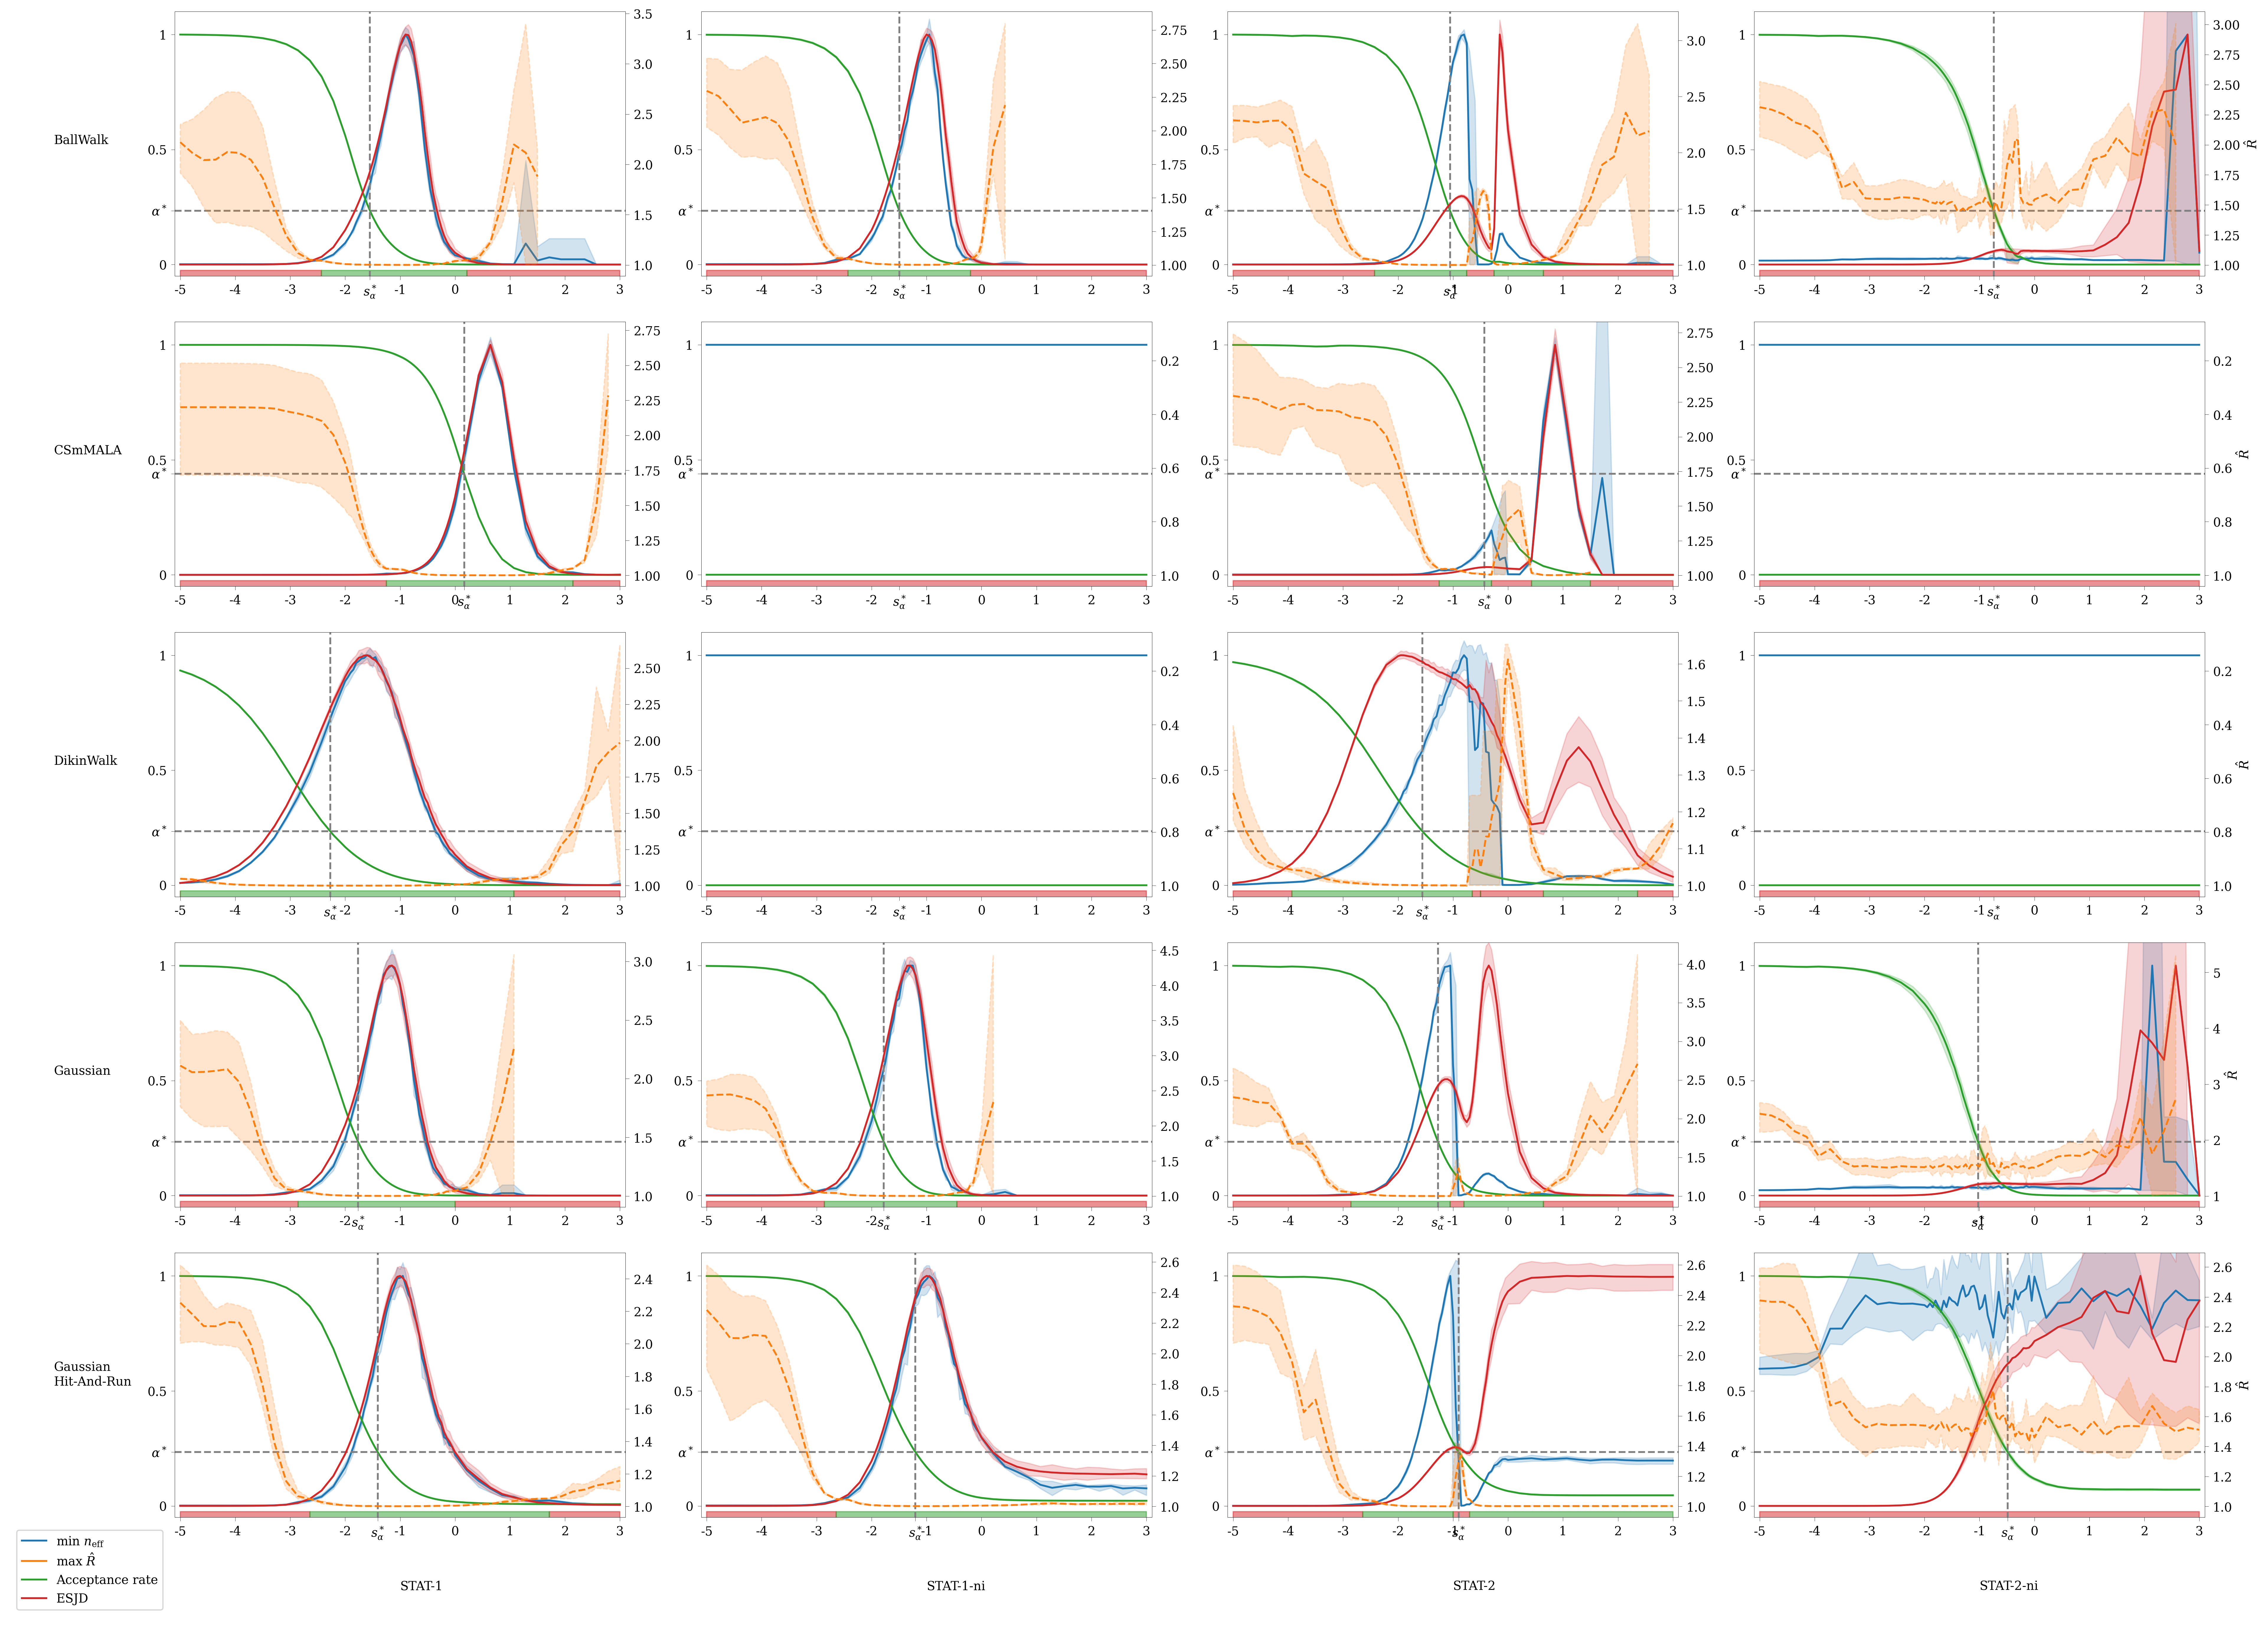

In [19]:
def collect_connected_sets(x, good):
    cs_good = []
    cs_bad = []
    last_good_start = None
    last_bad_start = x[0]
    for i in range(len(x)):
        if good[i] and last_good_start is None:
            last_good_start = x[i]
            cs_bad.append((last_bad_start, x[i]))
        if not good[i] and last_good_start is not None:
            cs_good.append((last_good_start, x[i-1]))
            last_good_start = None
            last_bad_start = x[i-1]
            
    if good[-1] and last_good_start is not None:
        cs_good.append((last_good_start, x[-1]))
    else:
        cs_bad.append((last_bad_start, x[-1]))
        
            
    return cs_good, cs_bad

plt.rcParams['axes.facecolor'] = 'white'

target_style = {
    r"min $n_{\mathrm{eff}}$": {'color': 'C0'},
    r"min $n_{\mathrm{eff}}$/t": {'color': 'C0', 'linestyle': 'dashed'},
    r"max $\hat{R}$": {'color': 'C1', 'linestyle': 'dashed'},
    "Acceptance rate": {'color': 'C2'},
    "ESJD": {'color': 'C3'},
    "ESJD/t": {'color': 'C3', 'linestyle': 'dashed'},
    "T/n": {'color': 'C4'},
}

alpha=1
gauss_opt_acc = .234
mala_opt_acc = .44

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rows, cols = len(proposals) + 1, len(problems) + 1
    fig, axs = plt.subplots(rows, cols, figsize=5*figsize, dpi=dpi, gridspec_kw={"height_ratios": [5]*(rows-1) + [1], "width_ratios": [1] + [5]*(cols-1)})

    fig.patch.set_facecolor('white')

    for i, problem_key in enumerate(problems):
        for proposal_idx, (proposal_name, proposal) in enumerate(proposals.items()):
            opt_acc = mala_opt_acc if proposal_name == 'CSmMALA' else gauss_opt_acc
            
            ax1 = axs[proposal_idx, i+1]
            ax2 = ax1.twinx()

            #rows, cols = 1, 1
            #fig, ax1 = plt.subplots(rows, cols, figsize=(16, 9), dpi=100)#, gridspec_kw={"height_ratios": [5]*(rows) + [1], "width_ratios": [1] + [5]*(cols-1)})

            a, b = np.log10(stepsize_grid[0])-.1, np.log10(stepsize_grid[-1])+.1
            
            for problem_idx, (dim, _, _) in enumerate(problems[problem_key]):
                for target_idx, target in enumerate(targets):
                    if target in [r"min $n_{\mathrm{eff}}$/t", "ESJD/t", "T/n"]: continue
                    
                    y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)
                    
                    y_mean = np.mean(y, axis=-1) 
                    
                    if target not in ["Acceptance rate", r"max $\hat{R}$"]:
                        y /= np.max(y_mean)
                        y_mean /= np.max(y_mean)

                    y_err = (np.quantile(y, 0.05, axis=-1), np.quantile(y, 0.95, axis=-1))

                    if target == r"max $\hat{R}$":
                        ax2.plot(np.log10(stepsize_grid), y_mean, label=target, alpha=alpha, **target_style[target])
                        ax2.fill_between(np.log10(stepsize_grid), y_err[0], y_err[1], alpha=.2*alpha, **target_style[target])
                        
                        is_good = (y_mean <= rhat_threshold)
                        good, bad = collect_connected_sets(np.log10(stepsize_grid), is_good)
                        
                        for xa, xb in bad:
                            ax1.fill_between([xa, xb], [-1, -1], [-.025], color='C3', zorder = -6, alpha=.5)
                            
                        for xa, xb in good:
                            ax1.fill_between([xa, xb], [-1, -1], [-.025], color='C2', zorder = -5, alpha=.5)
                            
                        
                        #bad = (y_mean > rhat_threshold) + (np.isnan(y_mean))
                        #ones = np.ones(stepsize_grid.shape)
                        
                        #good_upper = good * ones - 1.025
                        #bad_upper = bad * ones - 1.025
                        
                        #ax1.fill_between(np.log10(stepsize_grid), -1*ones, bad_upper, color='C3', zorder = -6, alpha=.5)
                        #ax1.fill_between(np.log10(stepsize_grid), -1*ones, good_upper, color='C2', zorder = -5, alpha=1)
                    else:
                        ax1.plot(np.log10(stepsize_grid), y_mean, label=target, alpha=alpha, **target_style[target])
                        ax1.fill_between(np.log10(stepsize_grid), y_err[0], y_err[1], alpha=.2*alpha, **target_style[target])
                        
                    if target == "Acceptance rate":
                        diff = y_mean - opt_acc
                        if diff[0] > 0 and diff[-1] < 0:
                            last_pos_idx = np.where(diff > 0)[-1][-1]
                            x1 = np.log10(stepsize_grid)[last_pos_idx]
                            y1 = y_mean[last_pos_idx]
                            x2 = np.log10(stepsize_grid)[last_pos_idx+1]
                            y2 = y_mean[last_pos_idx+1]

                            m = (y2 - y1) / (x2 - x1)
                            c = y1 - m * x1

                            x_opt_acc = (opt_acc - c) / m

                            ax1.plot([x_opt_acc, x_opt_acc], [-.1, 1.1], linestyle='dashed', color='gray')
                        ax1.plot([a, b], [opt_acc, opt_acc], linestyle='dashed', color='gray')
                            
            ax1.set_yticks([0, opt_acc, .5, 1], [0, r"$\alpha^*$", .5, 1])
            ax1.set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, x_opt_acc], [-5, -4, -3, -2, -1, 0, 1, 2, 3, r"$s_{\alpha}^*$"])
            
            ylim1 = [-.05, 1.1]
            ax1.set_xlim([a, b])
            ax1.set_ylim(ylim1)
            ylim2 = list(ax2.get_ylim())
            p = np.abs(ylim1[0]) / (ylim1[1] - ylim1[0])
            ylim2[0] = 1 - p*(ylim2[1] - 1)
            ax2.set_ylim(ylim2)
            
            #ax1.set_ylabel('normalized statistic')
            if i+1 == len(problems):
                ax2.set_ylabel(r"$\hat{R}$")

            #ax1.legend()
            #ax2.legend()
            
    #handles, labels = axs[proposal_idx, i].get_legend_handles_labels()
    #fig.legend(handles, labels, loc=(.07, .07))
            
    for i in range(rows-1):
        axs[i, 0].axis('off')
        axs[i, 0].text(.5, .5, list(proposals)[i])

    for i in range(1, cols):
        axs[-1, i].axis('off')
        axs[-1, i].text(.5, .5, list(problems)[i-1])

    axs[rows-1, 0].axis('off')
    
    custom_lines = [Line2D([0], [0], color='C0'),
                    Line2D([0], [0], color='C1'),
                    Line2D([0], [0], color='C2'),
                    Line2D([0], [0], color='C3'),
                   ]

    #axs[rows-2, 1].legend(custom_lines, [r"min $n_{\mathrm{eff}}$", r"max $\hat{R}$", "Acceptance Rate", "ESJD",], loc=(-.35, -.35))
    axs[rows-2, 1].legend(custom_lines, [r"min $n_{\mathrm{eff}}$", r"max $\hat{R}$", "Acceptance rate", "ESJD",], loc=(-.35, -.35))
    
    plt.show()


In [162]:
def kernel(x, y, l = 1, sigma = 1):
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)

def aggregate_errors(x, x_obs, y_obs, sigma_obs):
    sigma_x = np.mean(sigma_obs)**2 * np.ones(x.shape)
    for i, _ in enumerate(x):
        mean = 0
        count = 0
        for j, _ in enumerate(x_obs):
            if x[i] == x_obs[j]:
                count += 1
                mean += y_obs[j]
                sigma_x[i] += sigma_obs[j]**2 + y_obs[j]**2
        
        if count > 0:
            mean /= count
            sigma_x[i] /= count
            sigma_x[i] -= mean**2
            
    return sigma_x.reshape(-1, 1)
        
    
    
def posterior(x, x_obs, y_obs, l = 1, sigma_f = 1, sigma_y = 0, prior_mu = 0):
#    if (0 not in x_obs.shape):
    K = kernel(x_obs, x_obs, l, sigma_f) + sigma_y * np.eye(len(x_obs))
    K_s = kernel(x_obs, x, l, sigma_f)
    K_ss = kernel(x, x, l, sigma_f)
    K_inv = np.linalg.inv(K)

    #sigma_x = aggregate_errors(x, x_obs, y_obs, sigma_y)

    mu = prior_mu + K_s.T.dot(K_inv).dot(y_obs - prior_mu)
    cov = K_ss - K_s.T.dot(K_inv).dot(K_s) #+ sigma_y * np.eye(len(x))

    return mu, cov
#    else:
#        return np.ones(x.shape), np.eye(len(x))

gps = dict()

N = 200

for problem_key in problems:
    shape = (len(proposals), len(problems[problem_key]), N, 2)
    gps[problem_key] = np.zeros(shape)
       
        
for i, problem_key in enumerate(problems):
    for proposal_idx, (proposal_name, proposal) in enumerate(proposals.items()):
        for problem_idx, (dim, _, _) in enumerate(problems[problem_key]):
            target = "T/n"
            target_idx = list(targets).index(target)

            y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)
            y_mean = np.mean(y, axis=-1) 

            y /= np.max(y_mean)
            y_mean /= np.max(y_mean)

            X, Y = np.array([np.log10(stepsize_grid)]*y.shape[-1]).T.flatten().reshape(-1, 1), y.flatten().reshape(-1, 1)

            _x = np.linspace(-5, 3, N).reshape(-1, 1)
            mu, cov = posterior(_x, X, Y, sigma_y=.1, l=2)
            gps[problem_key][proposal_idx, problem_idx, :, 0] = mu.flatten()
            gps[problem_key][proposal_idx, problem_idx, :, 1] = np.sqrt(np.diag(cov)).flatten()


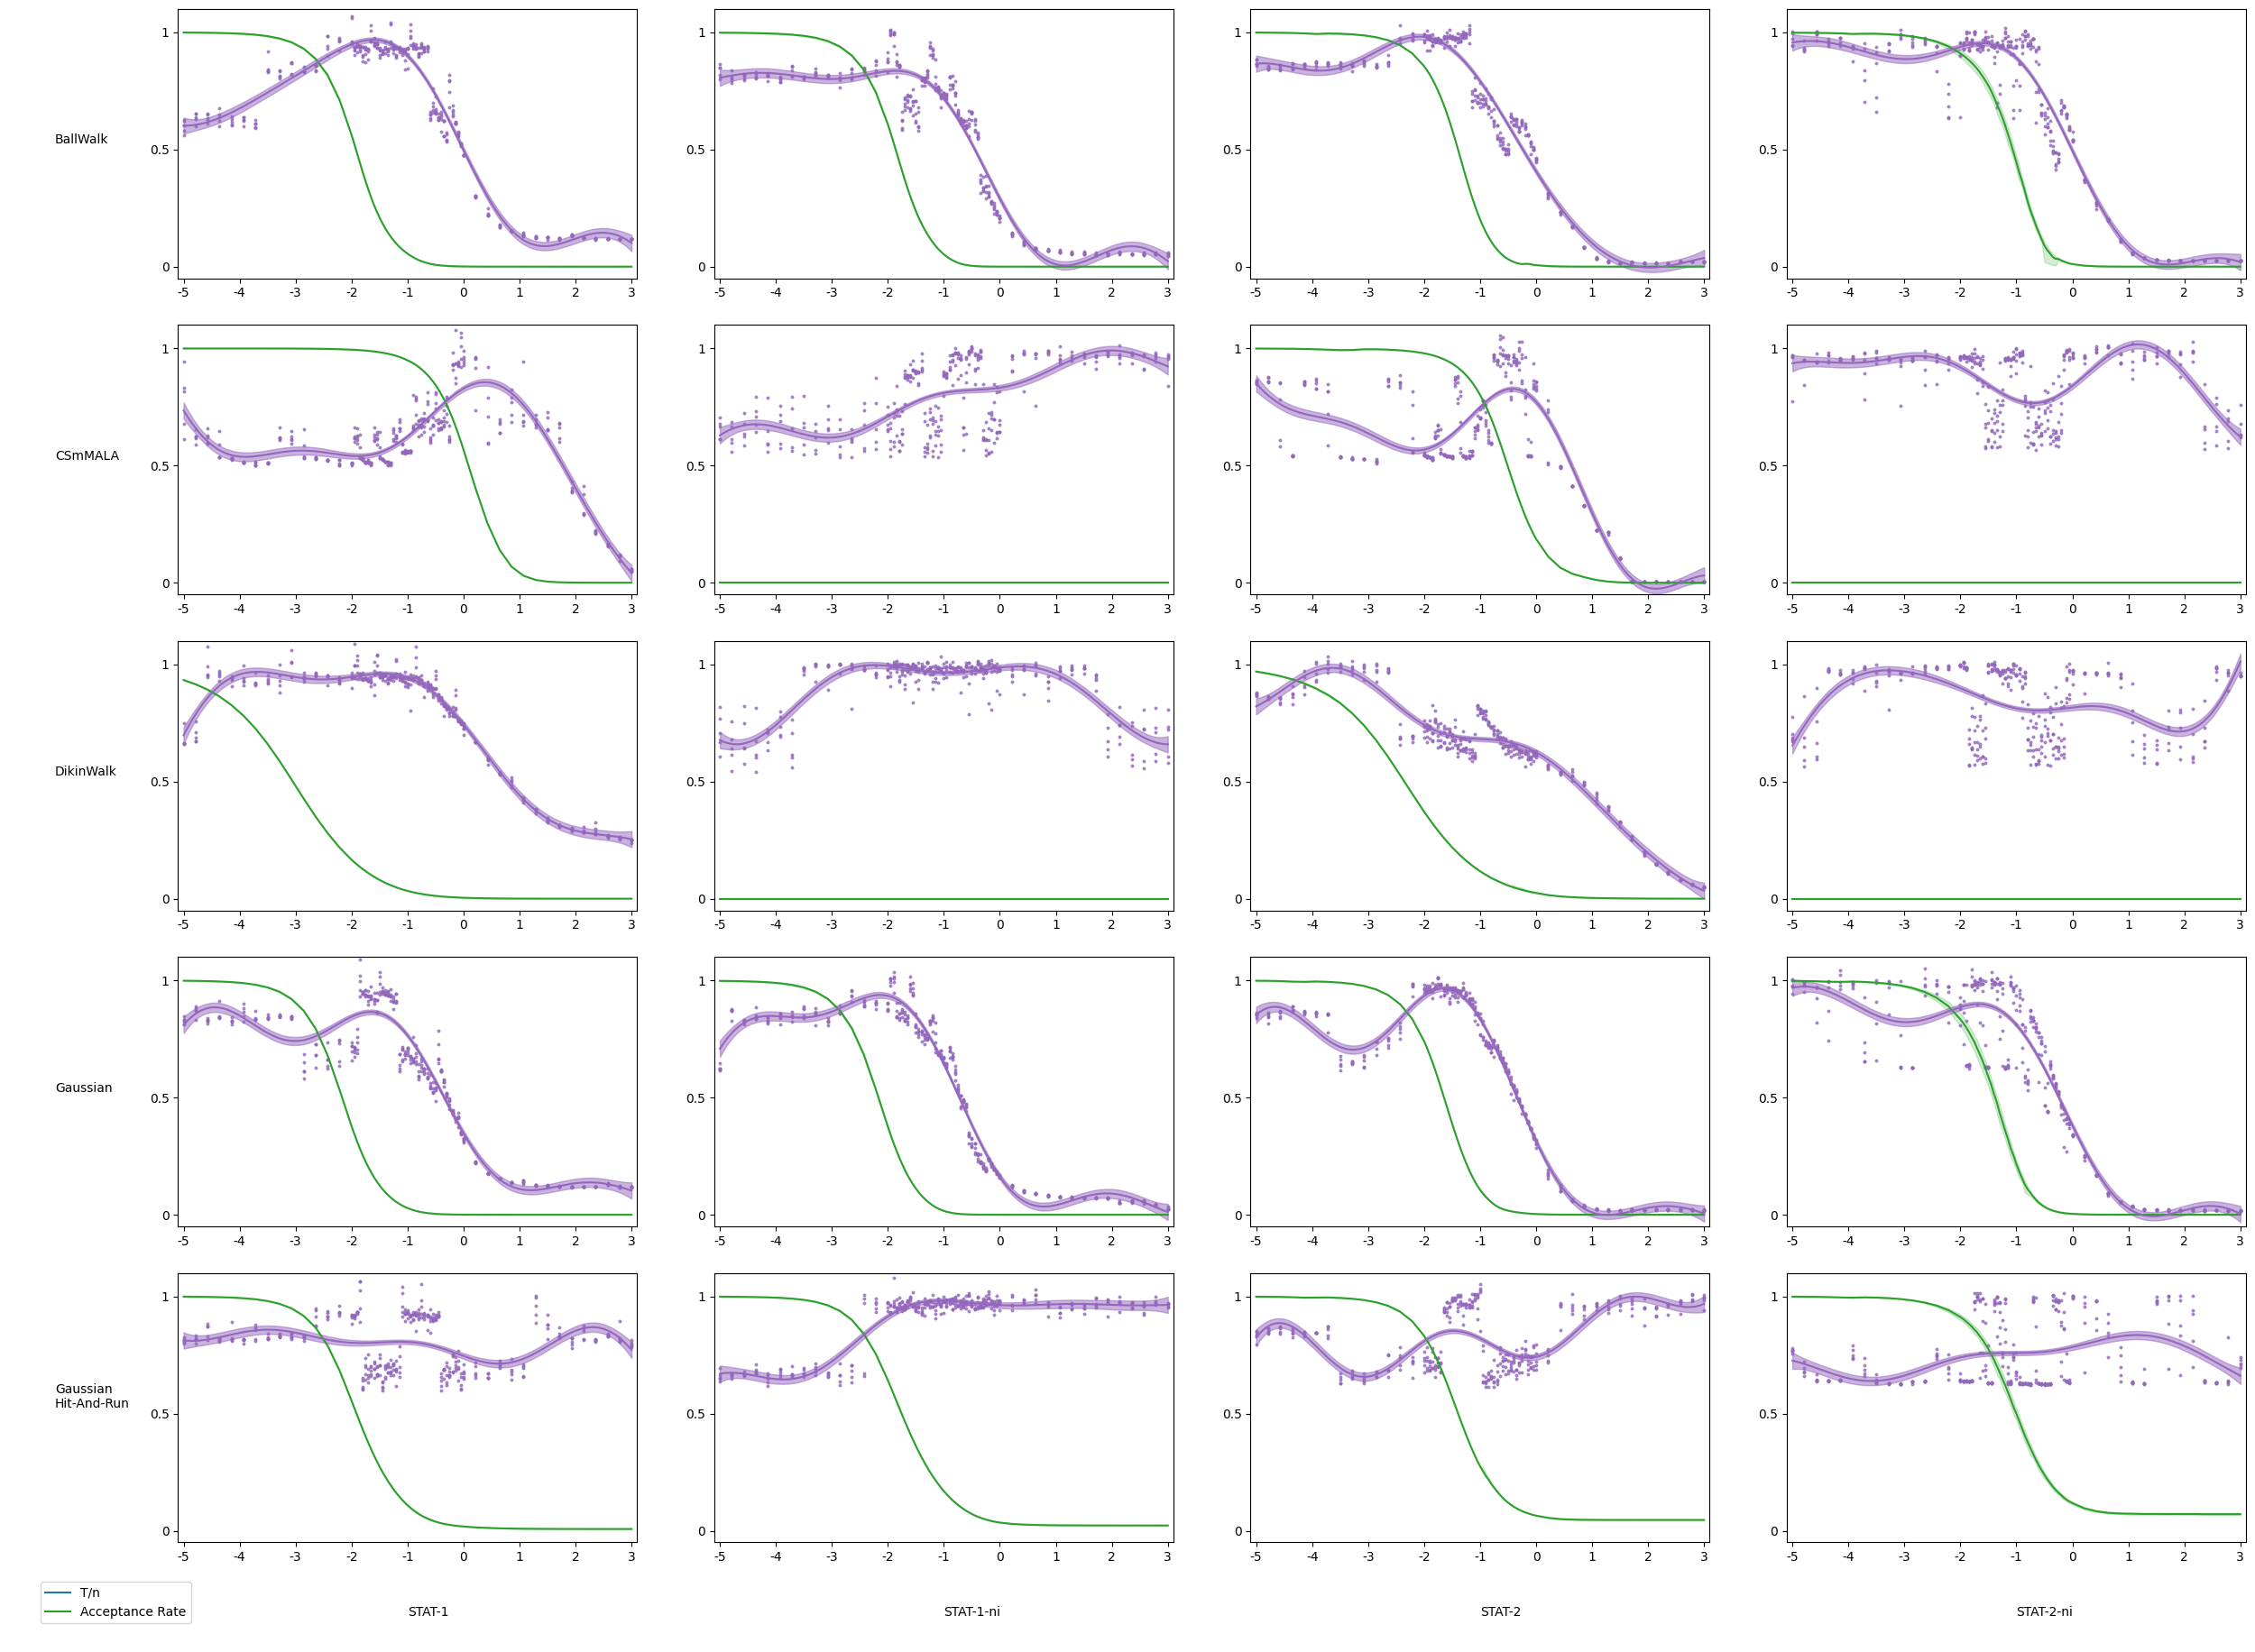

In [163]:
plt.rcParams['axes.facecolor'] = 'white'

target_style = {
    r"min $n_{\mathrm{eff}}$": {'color': 'C0'},
    r"min $n_{\mathrm{eff}}$/t": {'color': 'C0', 'linestyle': 'dashed'},
    r"max $\hat{R}$": {'color': 'C1', 'linestyle': 'dashed'},
    "Acceptance rate": {'color': 'C2'},
    "ESJD": {'color': 'C3'},
    "ESJD/t": {'color': 'C3', 'linestyle': 'dashed'},
    "T/n": {'color': 'C4'},
}

alpha=1
gauss_opt_acc = .234
mala_opt_acc = .44

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rows, cols = len(proposals)+1, len(problems)+1
    fig, axs = plt.subplots(rows, cols, figsize=5*figsize, dpi=dpi, gridspec_kw={"height_ratios": [5]*(rows-1) + [1], "width_ratios": [1] + [5]*(cols-1)})

    fig.patch.set_facecolor('white')

    for i, problem_key in enumerate(problems):
        for proposal_idx, (proposal_name, proposal) in enumerate(proposals.items()):
            ax1 = axs[proposal_idx, i+1]
            opt_acc = mala_opt_acc if proposal_name == 'CSmMALA' else gauss_opt_acc
            
            a, b = np.log10(stepsize_grid[0])-.1, np.log10(stepsize_grid[-1])+.1
            
            for problem_idx, (dim, _, _) in enumerate(problems[problem_key]):
                for target_idx, target in enumerate(targets):
                    if target in [r"max $\hat{R}$", r"min $n_{\mathrm{eff}}$/t", r"min $n_{\mathrm{eff}}$", "ESJD/t", "ESJD"]: continue
                    
                    y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)
                    
                    y_mean = np.mean(y, axis=-1) 
                    
                    if target not in ["Acceptance rate", r"max $\hat{R}$"]:
                        y /= np.max(y_mean)
                        y_mean /= np.max(y_mean)

                    if target == "T/n":
                        X, Y = np.array([np.log10(stepsize_grid)]*y.shape[-1]).T.flatten().reshape(-1, 1), y.flatten().reshape(-1, 1)

                        ax1.scatter(X, Y, s=3, alpha=.1, **target_style[target])

                        _x = np.linspace(-5, 3, 200)
                        mu, std = gps[problem_key][proposal_idx, problem_idx,:,0], gps[problem_key][proposal_idx, problem_idx,:,1]

                        ax1.plot(_x, mu, **target_style[target])
                        ax1.fill_between(_x, mu - std, mu + std, alpha=.5, **target_style[target])
                    else:
                        y_err = (np.quantile(y, 0.05, axis=-1), np.quantile(y, 0.95, axis=-1))
                        
                        ax1.plot(np.log10(stepsize_grid), y_mean, label=target, alpha=alpha, **target_style[target])
                        ax1.fill_between(np.log10(stepsize_grid), y_err[0], y_err[1], alpha=.2*alpha, **target_style[target])                        
                        
                    if target == "Acceptance rate":
                        diff = y_mean - opt_acc
                        if diff[0] > 0 and diff[-1] < 0:
                            last_pos_idx = np.where(diff > 0)[-1][-1]
                            x1 = np.log10(stepsize_grid)[last_pos_idx]
                            y1 = y_mean[last_pos_idx]
                            x2 = np.log10(stepsize_grid)[last_pos_idx+1]
                            y2 = y_mean[last_pos_idx+1]

                            m = (y2 - y1) / (x2 - x1)
                            c = y1 - m * x1

                            x_opt_acc = (opt_acc - c) / m

                            #ax1.plot([x_opt_acc, x_opt_acc], [-.1, 1.1], linestyle='dashed', color='gray')
                            #ax1.plot([a, b], [opt_acc, opt_acc], linestyle='dashed', color='gray')
                            
            ax1.set_yticks([0, .5, 1], [0, .5, 1])
            ax1.set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3], [-5, -4, -3, -2, -1, 0, 1, 2, 3])
            
            ylim1 = [-.05, 1.1]
            ax1.set_xlim([a, b])
            ax1.set_ylim(ylim1)
            
            
    for i in range(rows-1):
        axs[i, 0].axis('off')
        axs[i, 0].text(.5, .5, list(proposals)[i])

    for i in range(1, cols):
        axs[-1, i].axis('off')
        axs[-1, i].text(.5, .5, list(problems)[i-1])

    axs[rows-1, 0].axis('off')
    
    custom_lines = [Line2D([0], [0], color='C0'),
                    Line2D([0], [0], color='C2'),
                   ]

    axs[rows-2, 1].legend(custom_lines, ["T/n", "Acceptance rate",], loc=(-.3, -.3))
    
    plt.show()


[1.5, 8.5, 15.5, 22.5]


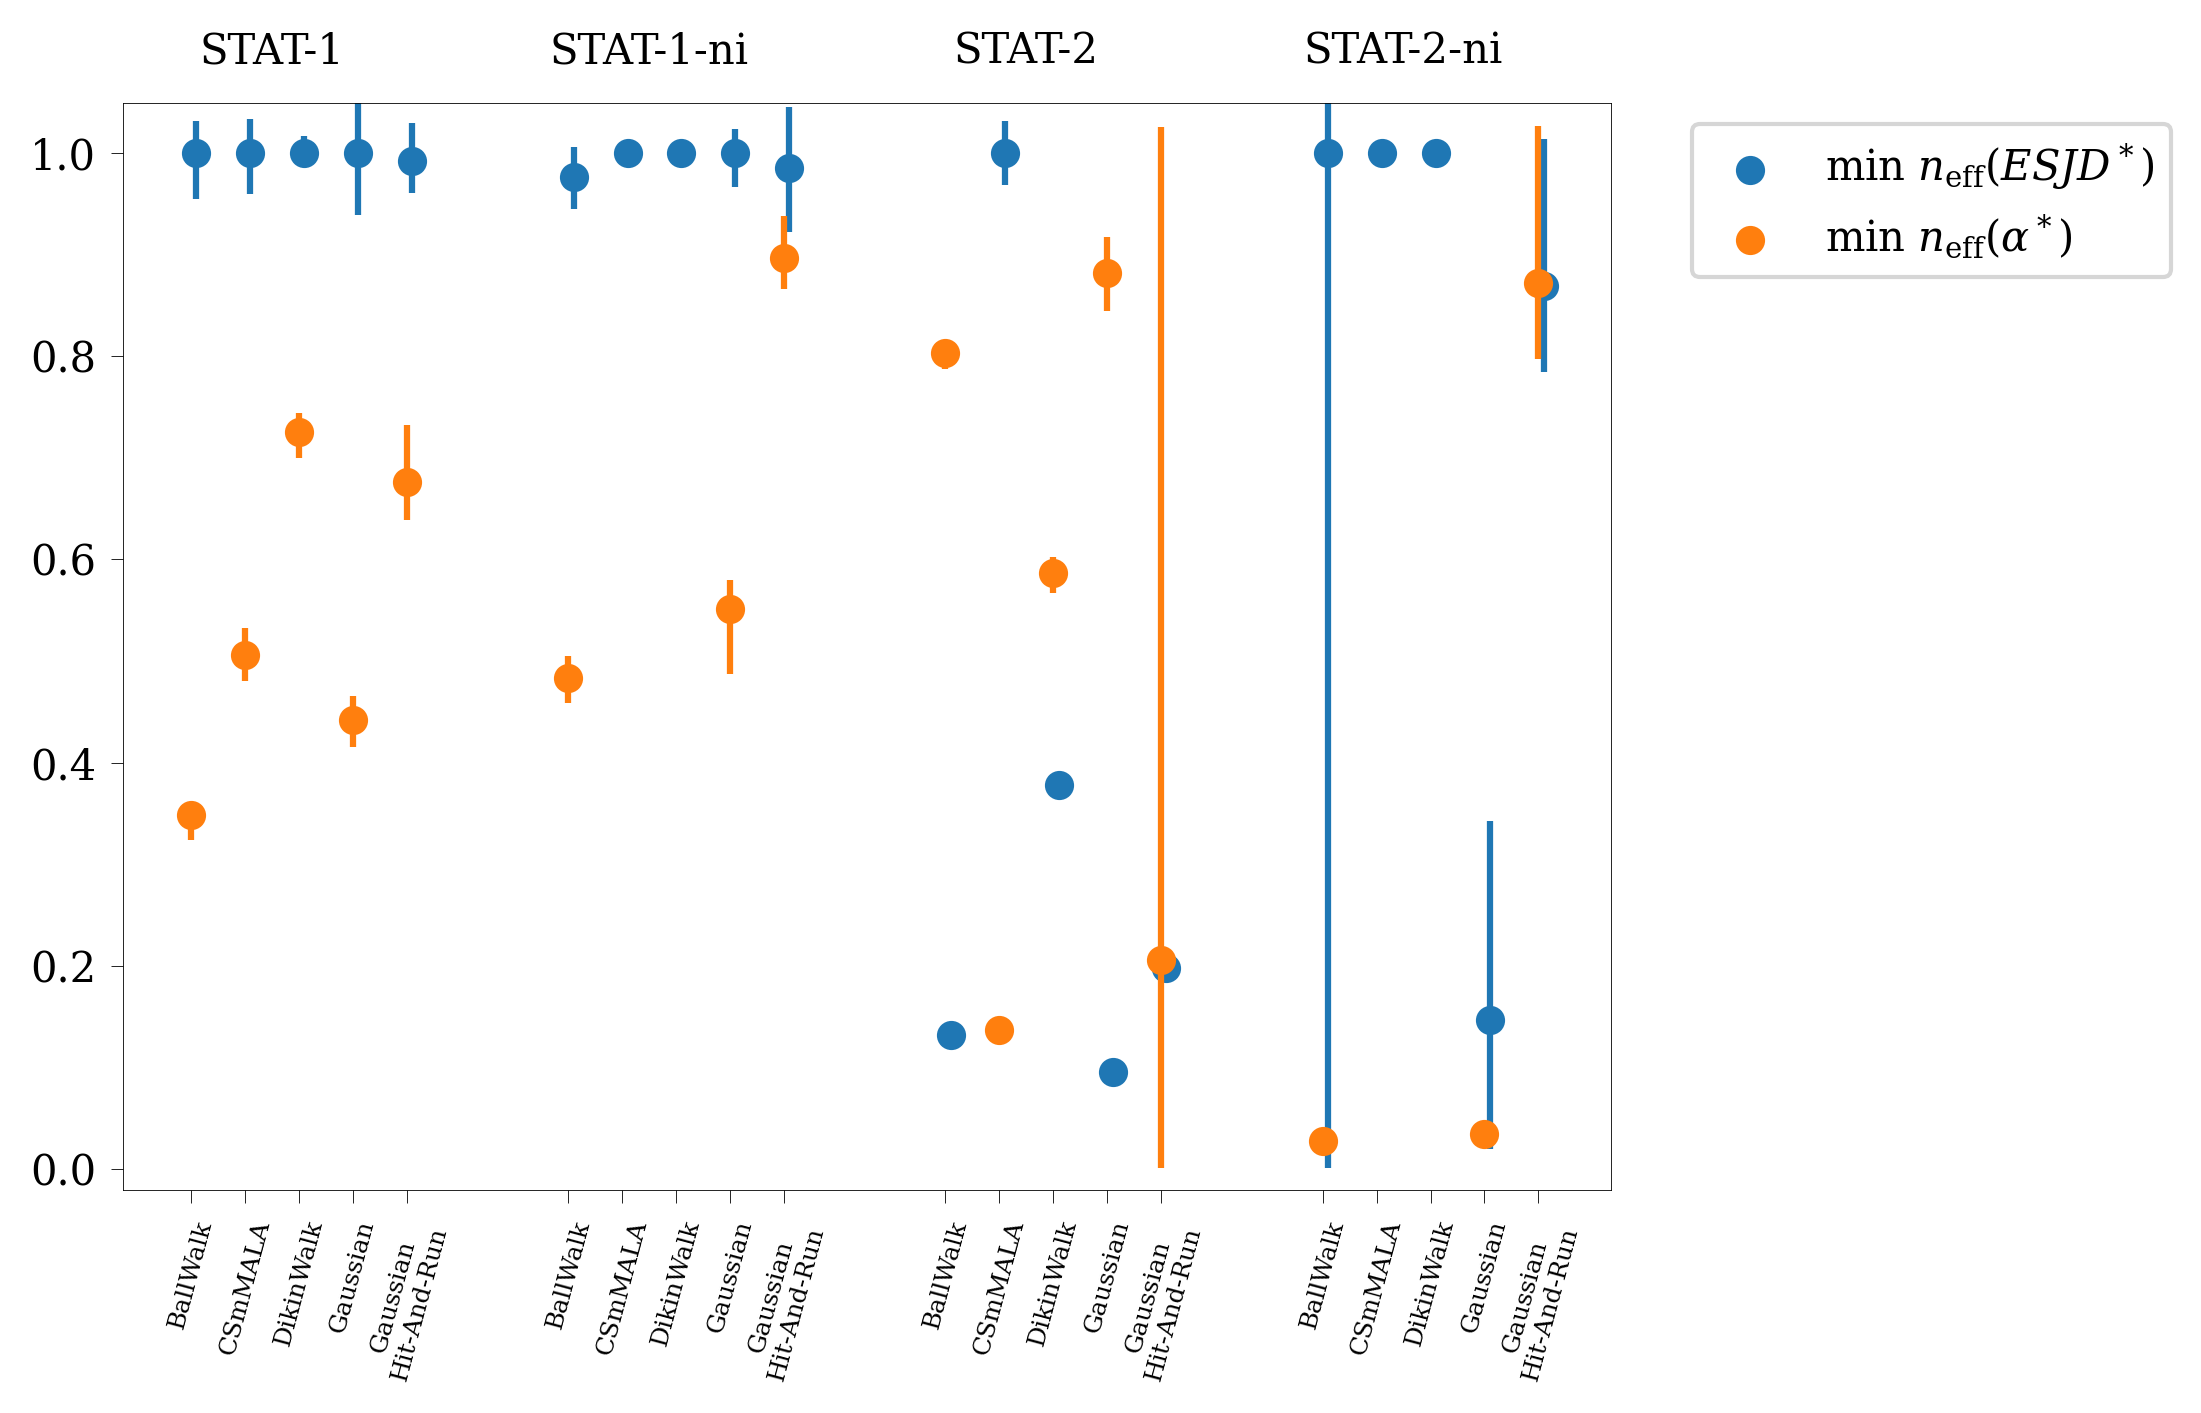

In [18]:
def collect_connected_sets(x, good):
    cs_good = []
    cs_bad = []
    last_good_start = None
    last_bad_start = x[0]
    for i in range(len(x)):
        if good[i] and last_good_start is None:
            last_good_start = x[i]
            cs_bad.append((last_bad_start, x[i]))
        if not good[i] and last_good_start is not None:
            cs_good.append((last_good_start, x[i-1]))
            last_good_start = None
            last_bad_start = x[i-1]
            
    if good[-1] and last_good_start is not None:
        cs_good.append((last_good_start, x[-1]))
    else:
        cs_bad.append((last_bad_start, x[-1]))
        
            
    return cs_good, cs_bad

plt.rcParams['axes.facecolor'] = 'white'

target_style = {
    r"min $n_{\mathrm{eff}}$": {'color': 'C0'},
    r"min $n_{\mathrm{eff}}$/t": {'color': 'C0', 'linestyle': 'dashed'},
    r"max $\hat{R}$": {'color': 'C1', 'linestyle': 'dashed'},
    "Acceptance rate": {'color': 'C2'},
    "ESJD": {'color': 'C3'},
    "ESJD/t": {'color': 'C3', 'linestyle': 'dashed'},
    "T/n": {'color': 'C4'},
}

group_by_proposal = False

alpha=1
gauss_opt_acc = .234
mala_opt_acc = .44

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rows, cols = 1, 1
    fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)#, gridspec_kw={"height_ratios": [5]*(rows-1) + [1], "width_ratios": [1] + [5]*(cols-1)})

    fig.patch.set_facecolor('white')
    
    x = []
    acc_good = []
    esjd_good = []
    neff_accs = []
    neff_esjds = []
    neff_accs_err = []
    neff_esjds_err = []

    for i, problem_key in enumerate(problems):
        for proposal_idx, (proposal_name, proposal) in enumerate(proposals.items()):
            opt_acc = mala_opt_acc if proposal_name == 'CSmMALA' else gauss_opt_acc
            
            for problem_idx, (dim, _, _) in enumerate(problems[problem_key]):
                if group_by_proposal:
                    x.append((len(problems) + 2)*proposal_idx + i)
                else:
                    x.append((len(proposals) + 2)*i + proposal_idx)
                
                target = r"min $n_{\mathrm{eff}}$"
                target_idx = list(targets).index(target)

                y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)

                y_mean = np.mean(y, axis=-1) 

                y /= np.max(y_mean)
                y_mean /= np.max(y_mean)

                y_err = (np.quantile(y, 0.05, axis=-1), np.quantile(y, 0.95, axis=-1))
                
                neff = y_mean
                neff_err = y_err
                
                y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)

                y_mean = np.mean(y, axis=-1) 

                y /= np.max(y_mean)
                y_mean /= np.max(y_mean)

                y_err = (np.quantile(y, 0.05, axis=-1), np.quantile(y, 0.95, axis=-1))
                
                for target in ["Acceptance rate", "ESJD"]:
                    target_idx = list(targets).index(target)
                    
                    y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)
                    y_mean = np.mean(y, axis=-1)
                    
                    if target == "ESJD":
                        y /= np.max(y_mean)
                        y_mean /= np.max(y_mean)

                        opt_esjd_idx = np.argmax(y_mean)
                        x_opt_esjd = np.log10(stepsize_grid)[opt_esjd_idx]
                    
                        neff_esjds.append(neff[opt_esjd_idx])
                        neff_esjds_err.append((neff_err[0][opt_esjd_idx], neff_err[1][opt_esjd_idx]))
                            
                    if target == "Acceptance rate":
                        diff = y_mean - opt_acc
                        if diff[0] > 0 and diff[-1] < 0:
                            last_pos_idx = np.where(diff > 0)[-1][-1]
                            x1 = np.log10(stepsize_grid)[last_pos_idx]
                            y1 = y_mean[last_pos_idx]
                            x2 = np.log10(stepsize_grid)[last_pos_idx+1]
                            y2 = y_mean[last_pos_idx+1]

                            m = (y2 - y1) / (x2 - x1)
                            c = y1 - m * x1

                            x_opt_acc = (opt_acc - c) / m

                            x1 = np.log10(stepsize_grid)[last_pos_idx]
                            y1 = neff[last_pos_idx]
                            x2 = np.log10(stepsize_grid)[last_pos_idx+1]
                            y2 = neff[last_pos_idx+1]
                            
                            m = (y2 - y1) / (x2 - x1)
                            c = y1 - m * x1

                            neff_acc = m * x_opt_acc + c
                            
                            neff_acc_err = [0, 0]
                            for j in range(len(neff_err)):
                                y1 = neff_err[j][last_pos_idx]
                                y2 = neff_err[j][last_pos_idx+1]

                                m = (y2 - y1) / (x2 - x1)
                                c = y1 - m * x1

                                neff_acc_err[j] = m * x_opt_acc + c
                            
                        else:
                            neff_acc = np.nan
                            neff_acc_err = [np.nan, np.nan]
                            
                        neff_accs.append(neff_acc)
                        neff_accs_err.append(neff_acc_err)
                        
    x = np.array(x)
    
    if group_by_proposal:
        x_group = [((len(problems) - 1) / 2) + (len(problems) + 2) * i for i in range(len(proposals))]
        for i, _x in enumerate(x_group):
            ax.text(_x, 1.1, list(proposals)[i], ha='center', va='center')
            
        xlabels = [name for name in problems] * len(proposals)
        ax.set_xticks(x)
        ax.set_xticklabels(xlabels, rotation=75, fontsize=6)
    else:
        x_group = [((len(problems)-1) / 2) + (len(proposals) + 2) * i for i in range(len(problems))]
        for i, _x in enumerate(x_group):
            ax.text(_x, 1.1, list(problems)[i], ha='center', va='center')
            
        xlabels = [name for name in proposals] * len(problems)
        ax.set_xticks(x)
        ax.set_xticklabels(xlabels, rotation=75, fontsize=6)
            
    print(x_group)

    neff_esjds_err = np.array((np.abs(np.array(neff_esjds_err)[:,0] - neff_esjds), np.abs(np.array(neff_esjds_err)[:,1] - neff_esjds)))
    
    ax.scatter(x+.1, neff_esjds, zorder=-1, color='C0', label=r'min $n_{\mathrm{eff}}(ESJD^*)$')
    ax.scatter(x, neff_accs, zorder=1, color='C1', label=r'min $n_{\mathrm{eff}}(\alpha^*)$')
    
    good = np.where(~np.isnan(neff_accs))
    
    neff_accs_err = np.array((np.abs(np.array(neff_accs_err)[:,0] - neff_accs), np.abs(np.array(neff_accs_err)[:,1] - neff_accs)))
    
    ax.errorbar(x, neff_accs, yerr=neff_accs_err, zorder=1, fmt='none', color='C1')
    ax.errorbar(x+.1, neff_esjds, yerr=neff_esjds_err, zorder=-1, fmt='none', color='C0')
    
    ax.set_ylim((-0.02082685768576953, 1.0486108027469414))
    
    #ax.bar(x, neff_accs, zorder=1, width=.25)
    #ax.bar(np.array(x)+.25, neff_esjds, zorder=-1, width=.25)
    
    ax.legend(bbox_to_anchor=(1.04, 1))
    
    plt.show()


In [51]:
with open("data/" + session + '_states', "rb") as fhandle:
    states_arr = dill.load(fhandle)

states = {problem_key: None for problem_key in problems}

for i, _states in enumerate(states_arr):
    states[list(problems)[i]] = _states


[[1.00001451 1.00001463]]


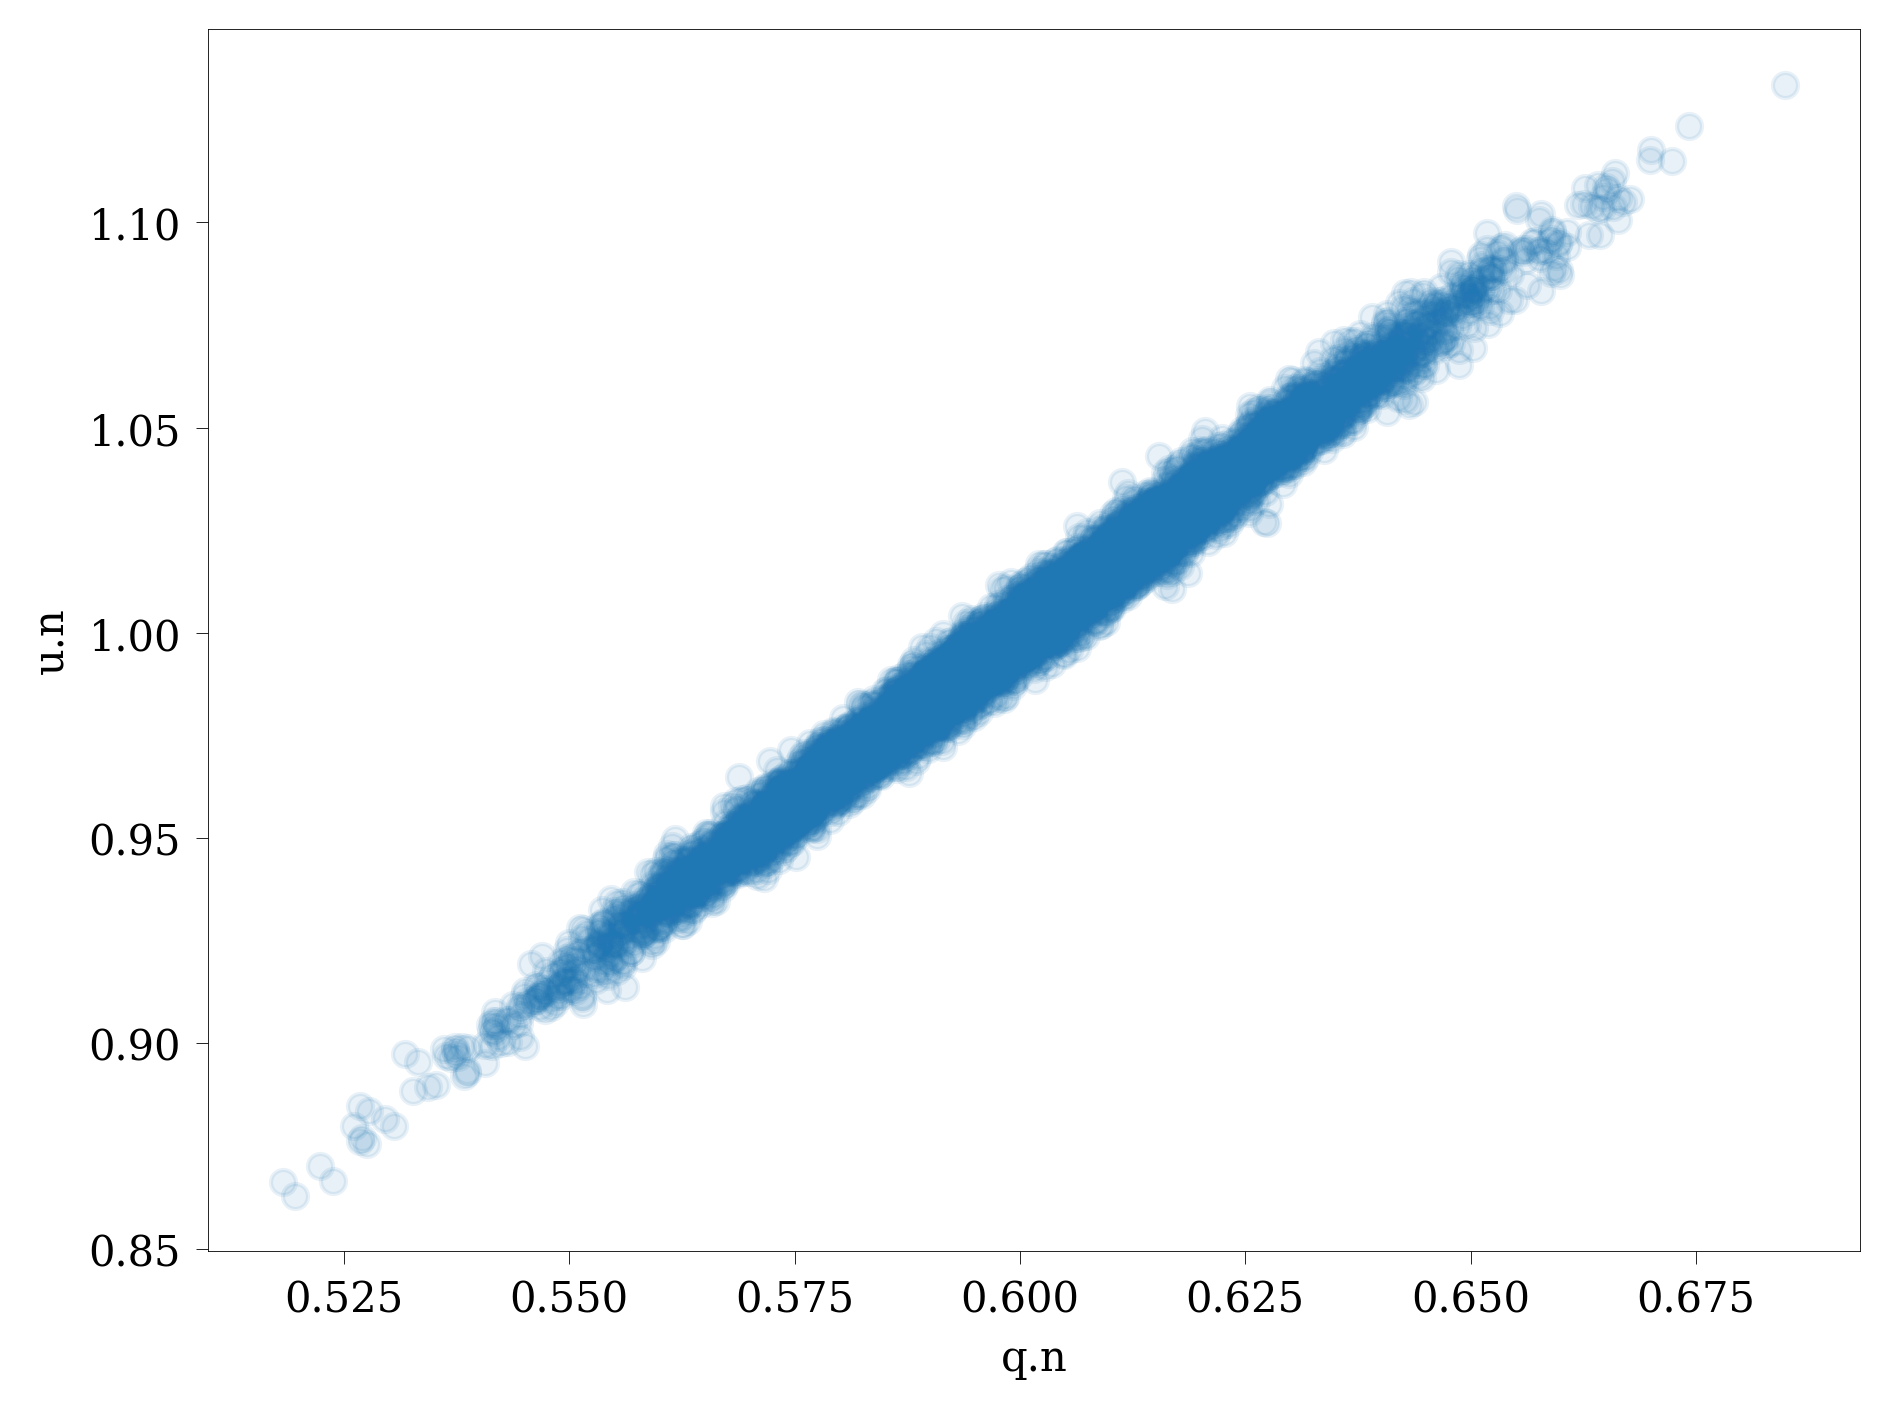

[[1.00004789 1.00003639 1.00004001]]


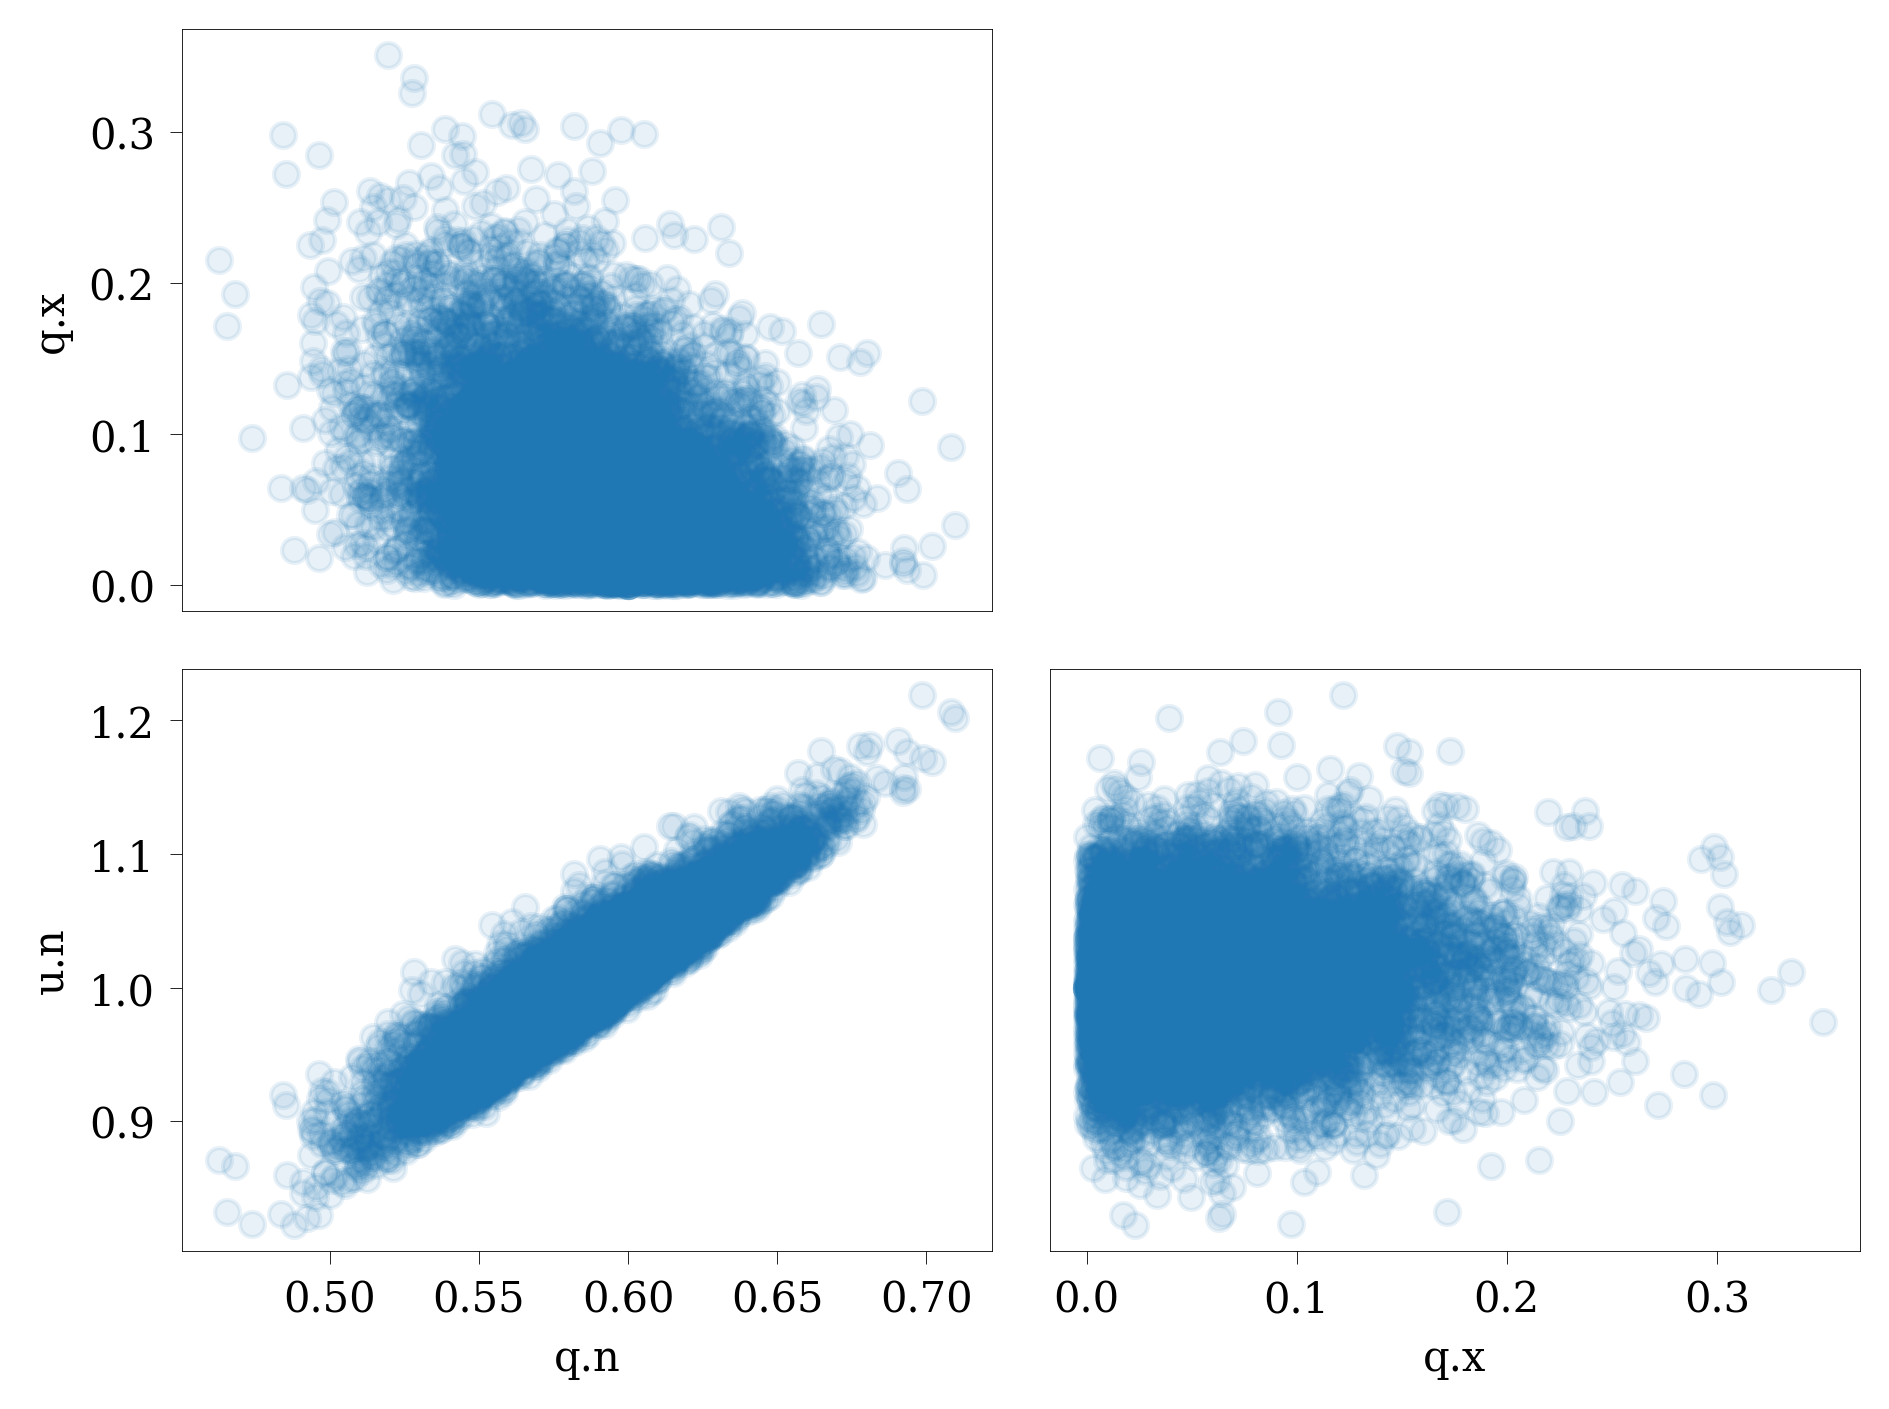

[[1.067438   1.00001987]]


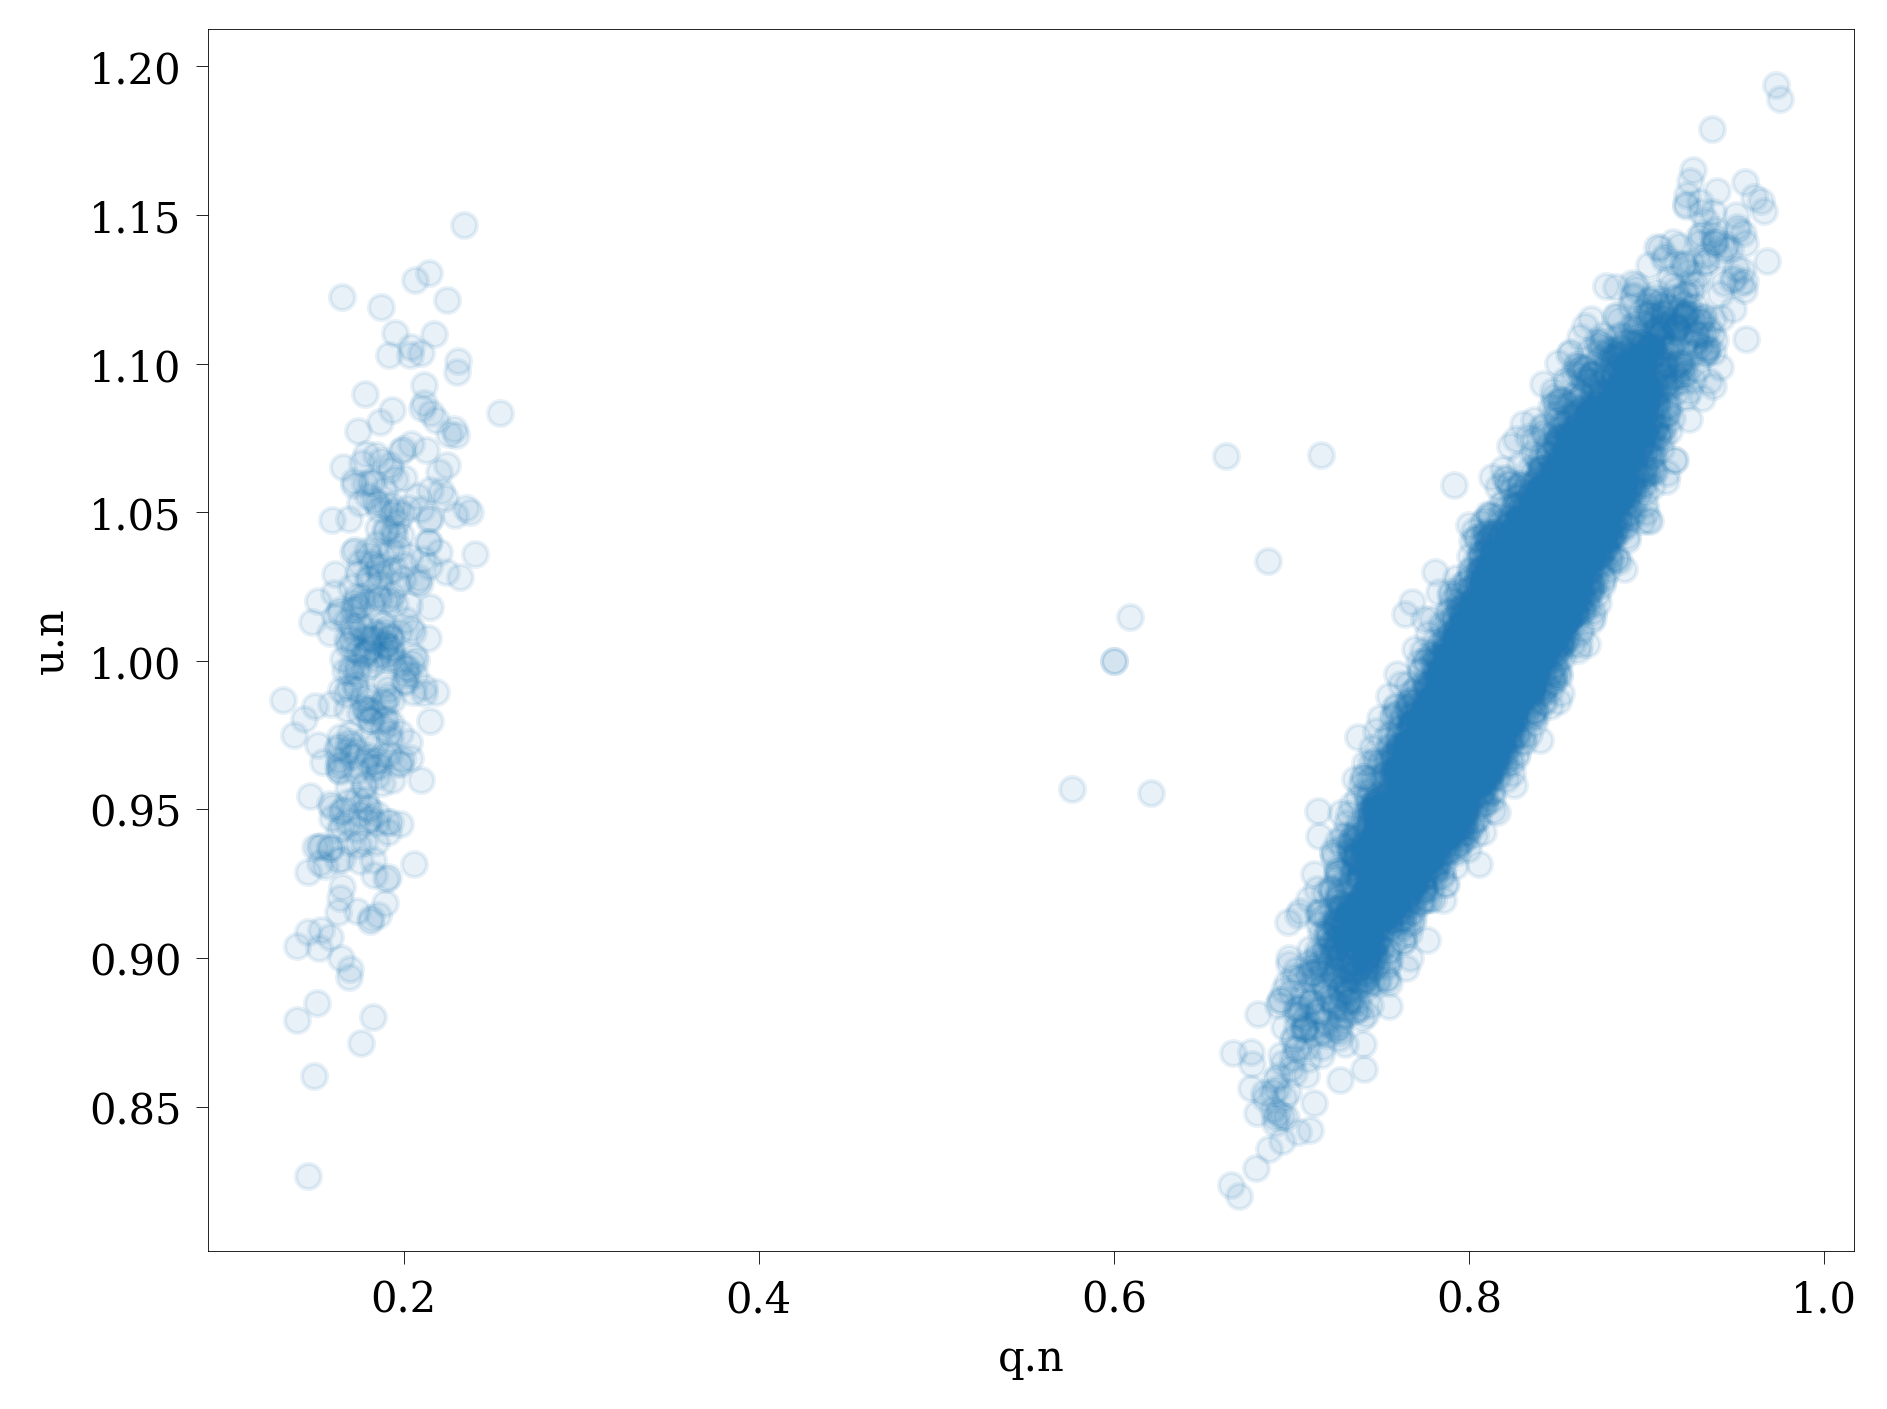

[[1.004726   1.4797185  1.00001008]]


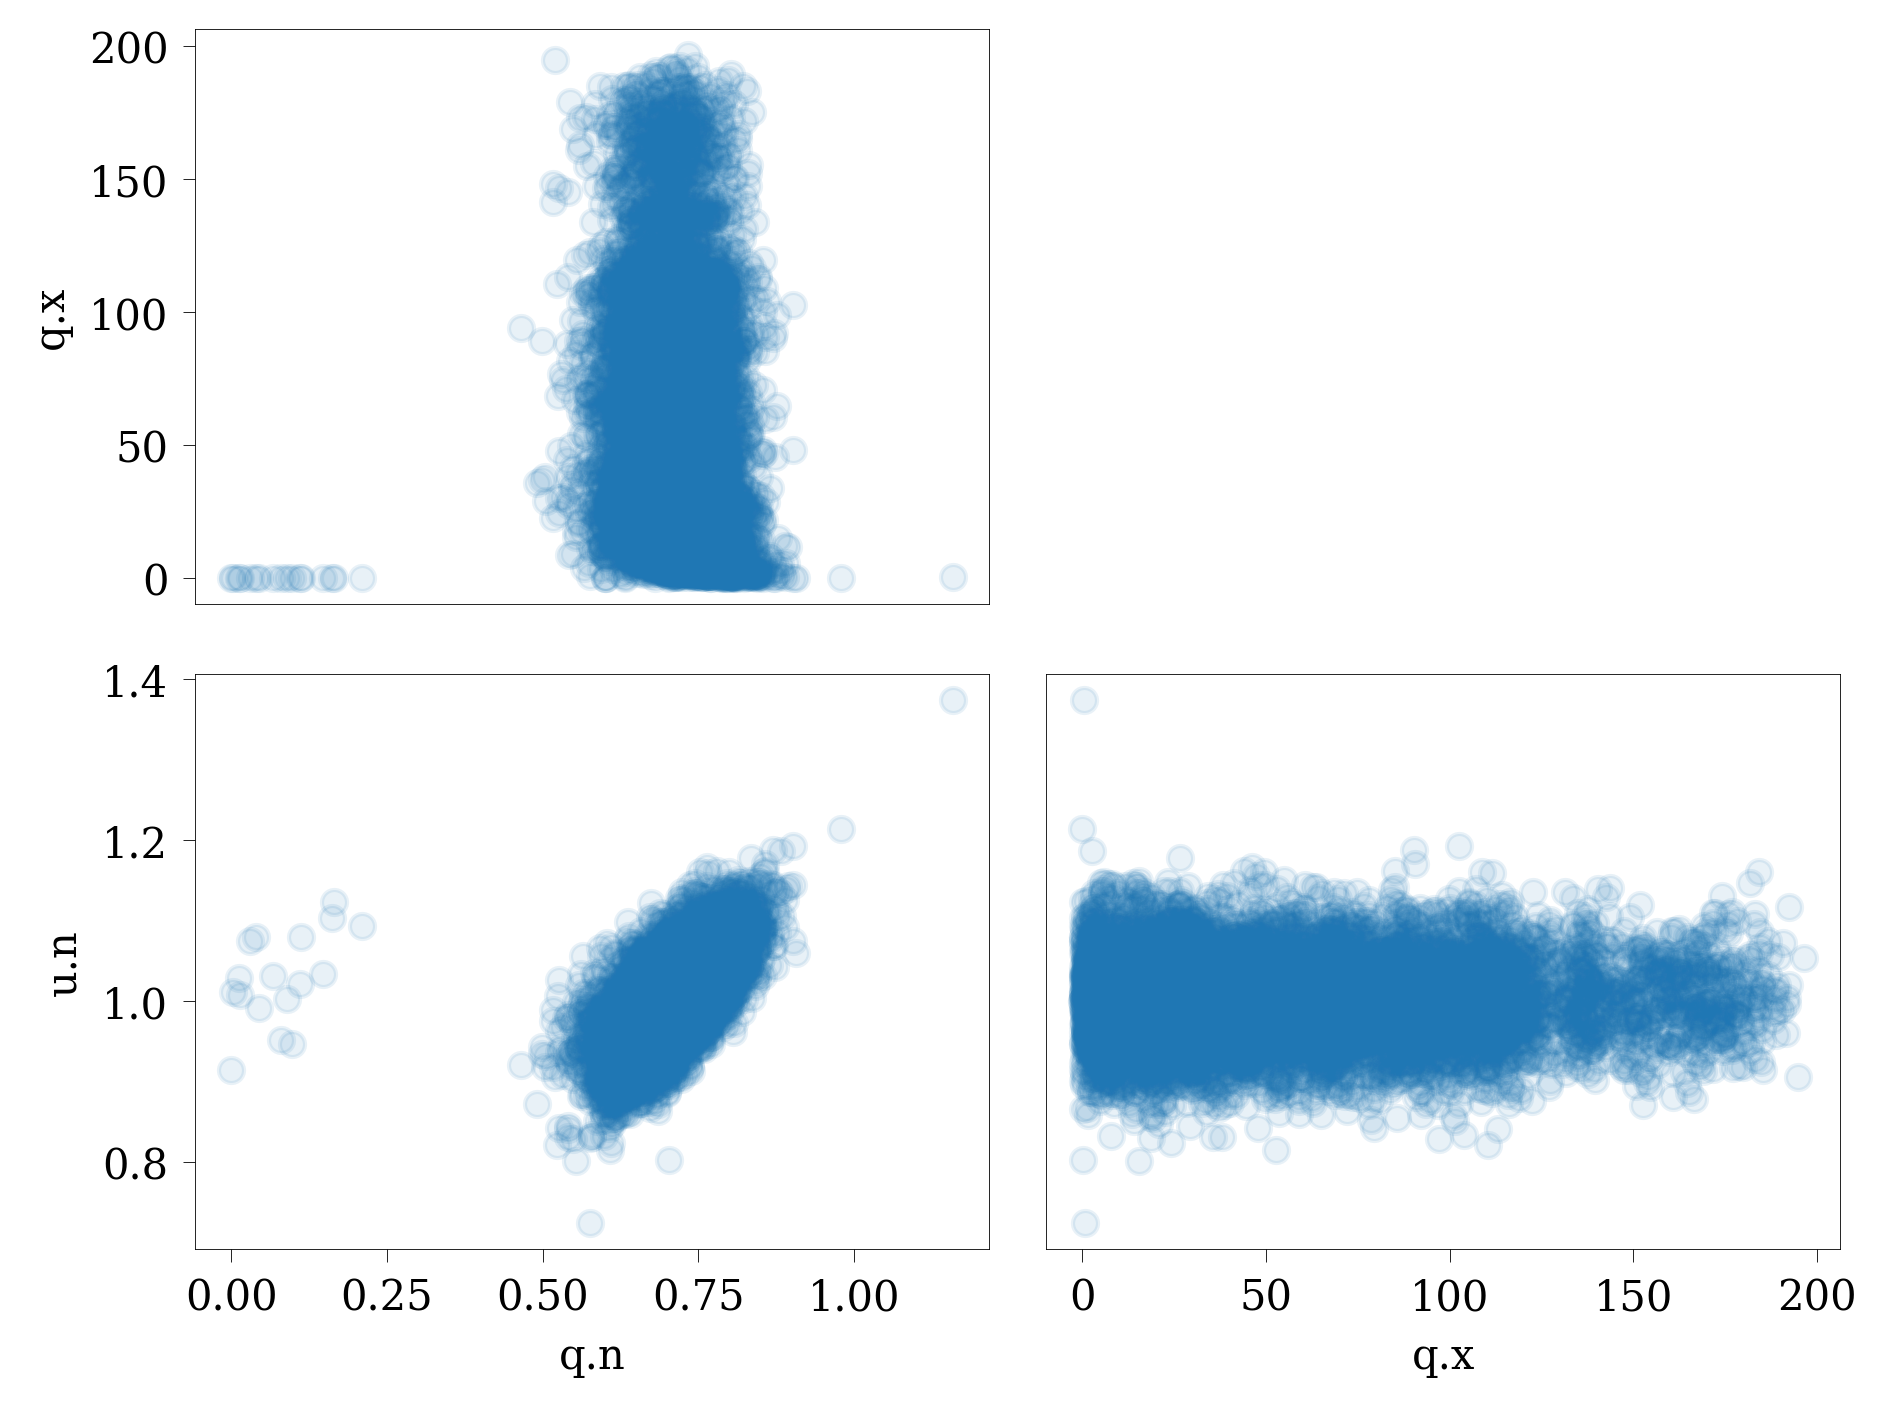

In [104]:
thinning = 1000

for key in states:
    dim = states[key].shape[-1]
    fig, axs = plt.subplots(dim-1, dim-1, dpi=dpi, figsize=figsize)
    
    param_names = problems[key][0][1].model.model.parameter_names
    
    if dim == 2:
        axs = np.array([[axs]])
        
    print(hopsy.rhat(states[key]))
        
    for i in range(dim-1):
        for j in range(i, dim-1):
            axs[j, i].scatter(states[key][:,::thinning,i].flatten(), 
                              states[key][:,::thinning,j+1].flatten(), alpha=.1)
            if j+1 == dim-1:
                axs[j, i].set_xlabel(param_names[i])
            else:
                axs[j, i].set_xticks([])
            
            if i == 0:
                axs[j, i].set_ylabel(param_names[j+1])
            else:
                axs[j, i].set_yticks([])
            
        for j in range(i):
            axs[j, i].axis('off')
            
    fig.tight_layout()
            
    plt.show()